In [1]:
addprocs(4)
using SeisIO, HDF5, PyPlot, opesciSLIM.TimeModeling

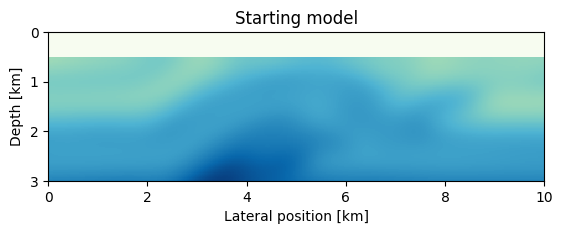

In [2]:
m0, n, d, o = read(h5open("overthrust_model.h5","r"),"m0","n","d","o"); title("Starting model")
model0 = Model((n[1],n[2]), (d[1],d[2]), (o[1],o[2]), m0);
imshow(sqrt.(1f0./m0)', cmap="GnBu", extent=(0,10,3,0));
xlabel("Lateral position [km]");
ylabel("Depth [km]");

In [3]:
block = segy_read("overthrust_shot_records.segy");
d_obs = joData(block);

In [4]:
println(typeof(d_obs))

opesciSLIM.TimeModeling.joData{Float32}


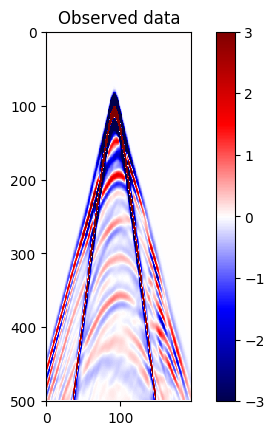

PyObject <matplotlib.text.Text object at 0x1217bbb50>

In [5]:
imshow(d_obs.data[15], cmap="seismic", vmin=-3, vmax=3); colorbar(); title("Observed data")

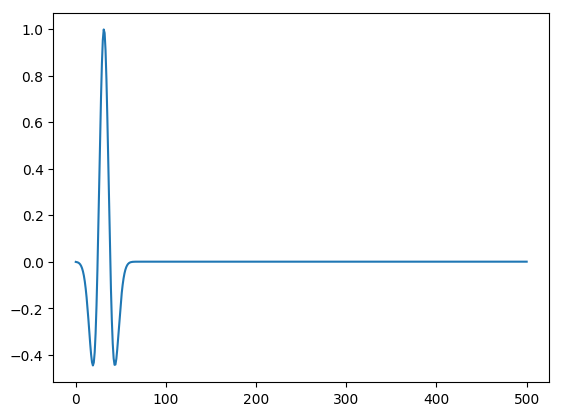

In [6]:
src_geometry = Geometry(block; key="source");
src_data = ricker_wavelet(src_geometry.t[1], src_geometry.dt[1], 0.008f0);
q = joData(src_geometry, src_data);
plot(q.data[1]);

In [7]:
ntComp = get_computational_nt(q.geometry, d_obs.geometry, model0);
info = Info(prod(model0.n), d_obs.nsrc, ntComp);

In [8]:
F = joModeling(info, model0);
Pr = joProjection(info, d_obs.geometry);
Ps = joProjection(info, q.geometry);

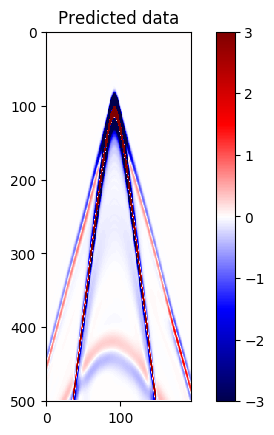

PyObject <matplotlib.text.Text object at 0x12537de90>

In [9]:
i = 15;
d_pred = Pr[i]*F[i]*Ps[i]'*q[i];
imshow(d_pred.data[1], cmap="seismic", vmin=-3, vmax=3); colorbar(); title("Predicted data")

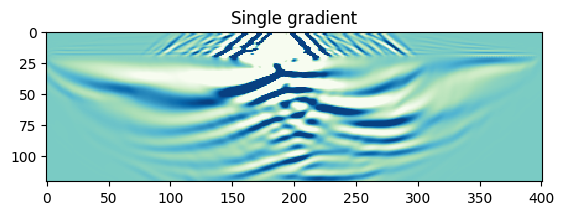

PyObject <matplotlib.text.Text object at 0x1297bc150>

In [10]:
J = joJacobian(Pr*F*Ps',q);
g = J[i]'*(d_pred - d_obs[i]);
imshow(reshape(g,model0.n)',vmin=-2e2,vmax=2e2, cmap="GnBu"); title("Single gradient")

This is a markdown cell $\mathbf{Ax} = \mathbf{b}$

In [11]:
# Set up bound constrains
v0 = sqrt.(1f0./model0.m)
vmin = ones(Float32, model0.n)*1.3f0;
vmax = ones(Float32, model0.n)*6.5f0;

# Fix water column
vmin[:,1:21] = v0[:,1:21];
vmax[:,1:21] = v0[:,1:21];

# Convert to squared slowness
mmin = vec((1f0./vmax).^2);
mmax = vec((1f0./vmin).^2);

In [29]:
model0.m = m0
maxiter = 10
batchsize = 4
proj(x) = reshape(median([vec(mmin) vec(x) vec(mmax)],2), model0.n)
fhistory = zeros(Float32,maxiter)

# Main loop
for j=1:maxiter
    println("Iteration: ",j)
    
    # get fwi objective function value and gradient
    i = randperm(d_obs.nsrc)[1:batchsize]
    fval, gradient = fwi_objective(model0, q[i], d_obs[i])
    fhistory[j] = fval

    # linesearch
    alpha = backtracking_linesearch(model0, q[i], d_obs[i], fval, gradient, proj; alpha=1f-5)
    model0.m = proj(model0.m - reshape(alpha*gradient, model0.n))
    
end

Iteration: 1
	Iter LS: 1; 11408.911 <= 48373.34; alpha: 1.0e-5
Iteration: 2
	Iter LS: 1; 9034.725 <= 33596.973; alpha: 1.0e-5
Iteration: 3
	Iter LS: 1; 7152.762 <= 28276.754; alpha: 1.0e-5
Iteration: 4
	Iter LS: 1; 6146.18 <= 19239.584; alpha: 1.0e-5
Iteration: 5
	Iter LS: 1; 9231.157 <= 14060.981; alpha: 1.0e-5
Iteration: 6
	Iter LS: 1; 35884.68 <= 19541.664; alpha: 1.0e-5
	Iter LS: 2; 6187.2407 <= 19541.664; alpha: 1.0e-6
Iteration: 7
	Iter LS: 1; 22188.285 <= 13943.801; alpha: 1.0e-5
	Iter LS: 2; 5250.3765 <= 13943.801; alpha: 1.0e-6
Iteration: 8
	Iter LS: 1; 4269.5205 <= 16329.454; alpha: 1.0e-5
Iteration: 9
	Iter LS: 1; 4814.2603 <= 10093.322; alpha: 1.0e-5
Iteration: 10
	Iter LS: 1; 3921.3333 <= 8226.671; alpha: 1.0e-5


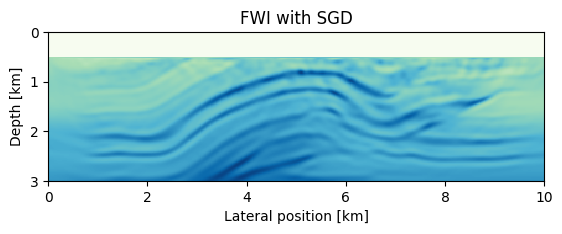

In [28]:
imshow(sqrt.(1f0./model0.m)', cmap="GnBu", extent=(0,10,3,0)); title("FWI with SGD")
xlabel("Lateral position [km]");
ylabel("Depth [km]");